In [3]:
!pip install xlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.2 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for xlearn: filename=xlearn-0.40a1-py3-none-any.whl size=225735 sha256=322fb40f74251ced96f6ecd4e4137ad78f81804c50836025a21189831b5b2ca9
  Stored in directory: /root/.cache/pip/wheels/09/48/04/779ee06b22532c86cde8da8984b83284517492dad1df998c6a
Successfully built xlearn


In [4]:
import xlearn as xl

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import datetime
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss,roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import ParameterGrid

Информация по датасету:

* date_time - время показа рекламы
* oaid_hash - хэш юзера
* zone_id - id зоны, где зона - место на сайте для размещения рекламы
* banner_id - id баннера, где баннер - сама реклама
* campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
* os_id - id операционной системы
* country_id - id страны
* banner_id0 - нулевой баннер в “стакане” баннеров
* banner_id1 - перый баннер в “стакане” баннеров
* rate0 - стоимость 1 клика установленная рекламодателем для banner_id0
* rate1 - стоимость 1 клика установленная рекламодателем для banner_id1
* g0 - стандартное отклонение предикта с banner_id0
* g1 - стандартное отклонение предикта с banner_id1
* coeff_sum0 - сумма коэффициентов для banner_id0
* coeff_sum1 - сумма коэффициентов для banner_id1
* impressions - был ли показ
* clicks - был ли клик


 колонки:  banner_id0, banner_id1, rate0, rate1, g0, g1, coeff_sum0, coeff_sum1 использовать не нужно

In [2]:
data = pd.read_csv('data.csv', parse_dates=['date_time'],infer_datetime_format=True)
columns_to_drop = ['oaid_hash','banner_id0','banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1']
data.drop(columns_to_drop, axis=1, inplace = True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


In [3]:
def plot_bar(df,title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    for i, col in enumerate(df.columns):
        df[col].plot(kind='bar', ax=axes[i])
        axes[i].set_title(col)
    plt.tight_layout()
    fig.suptitle(title,y=1.05)
    plt.show()

In [4]:
def analysis(data: pd.DataFrame):
    font_size = "20px"
    text ='Описательные характеристики'
    print('\n')
    display(HTML(f"<p style='font-size: {font_size}'>{text}</p>"))

    print('\nЧисло пропусков в данных:')
    display(pd.DataFrame(data.isnull().sum()))

    print('\nЧисло уникальных значений в столбцах:')
    display(pd.DataFrame(data.nunique()))

    print('\nОписательные статистики:')
    display(data.describe())

    columns_for_plotting = ['zone_id','banner_id','campaign_clicks','os_id', 'country_id','impressions','clicks']

    print('\nМатрица корреляции:')
    fig, axes = plt.subplots(figsize=(7, 5))
    sns.heatmap(data.corr(),cmap='YlGnBu', annot=True)
    plt.show()

    print('\nАнализ дат:')
    ind = ['Различных лет','Различных месяцев','Различных дат']
    dat = [ data.date_time.dt.year.nunique(),data.date_time.dt.month.nunique(),data.date_time.dt.date.nunique()]
    display(pd.DataFrame(data=dat, index=ind))

    print('\nАнализ времени:')
    ind = ['Различных часов']
    dat = [ data.date_time.dt.hour.nunique()]
    display(pd.DataFrame(data=dat, index=ind))


    font_size = "20px"
    text ='Анализ распределения кликов'
    print('\n')
    display(HTML(f"<p style='font-size: {font_size}'>{text}</p>"))



    print('\nЧисло действий по датам:')

    display(pd.DataFrame(data.groupby(data['date_time'].dt.date)['clicks'].count()))

    clicks_by_day = pd.DataFrame()
    grouping = data.groupby(data['date_time'].dt.date)['clicks']
    clicks_by_day['Число кликов'] = grouping.sum()
    clicks_by_day['Число отсутсвия кликов'] = grouping.apply(lambda x: (x == 0).sum())
    plot_bar(clicks_by_day,'Число действий по датам')

    print('\nЧисло действий по дням недели:')
    display(pd.DataFrame(data.groupby(data['date_time'].dt.dayofweek)['clicks'].count()))


    clicks_by_month = pd.DataFrame()
    grouping = data.groupby(data['date_time'].dt.dayofweek)['clicks']
    clicks_by_month['Число кликов'] = grouping.sum()
    clicks_by_month['Число отсутсвия кликов'] = grouping.apply(lambda x: (x == 0).sum())
    plot_bar(clicks_by_month,'Число действий по дням недели')


    print('\nЧисло действий по месяцам:')
    display(pd.DataFrame(data.groupby(data['date_time'].dt.month)['clicks'].count()))


    clicks_by_month = pd.DataFrame()
    grouping = data.groupby(data['date_time'].dt.month)['clicks']
    clicks_by_month['Число кликов'] = grouping.sum()
    clicks_by_month['Число отсутсвия кликов'] = grouping.apply(lambda x: (x == 0).sum())
    plot_bar(clicks_by_month,'Число действий по месяцам')



    print('\nЧисло действий по часам:')
    display(pd.DataFrame(data.groupby(data['date_time'].dt.hour)['clicks'].count()))


    clicks_by_month = pd.DataFrame()
    grouping = data.groupby(data['date_time'].dt.hour)['clicks']
    clicks_by_month['Число кликов'] = grouping.sum()
    clicks_by_month['Число отсутсвия кликов'] = grouping.apply(lambda x: (x == 0).sum())
    plot_bar(clicks_by_month,'Число действий по месяцам')


Число пропусков в данных:


,0
date_time,0
zone_id,0
banner_id,0
campaign_clicks,0
os_id,0
country_id,0
impressions,0
clicks,0



Число уникальных значений в столбцах:


,0
date_time,604712
zone_id,3444
banner_id,1633
campaign_clicks,822
os_id,11
country_id,17
impressions,1
clicks,2



Описательные статистики:


,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,6.238540e-01,1.840605e+00,4.346986e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,9.249152e+00,1.530005e+00,4.317701e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00



Матрица корреляции:


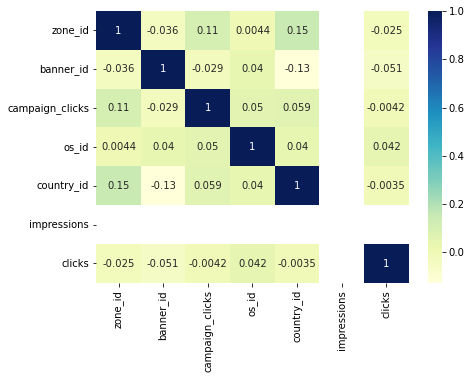


Анализ дат:


,0
Различных лет,1
Различных месяцев,2
Различных дат,8



Анализ времени:


,0
Различных часов,24



Число действий по датам:


,clicks
date_time,
2021-09-01,1
2021-09-26,3102610
2021-09-27,2367303
2021-09-28,2307355
2021-09-29,2420588
2021-09-30,1851189
2021-10-01,1643448
2021-10-02,2128978


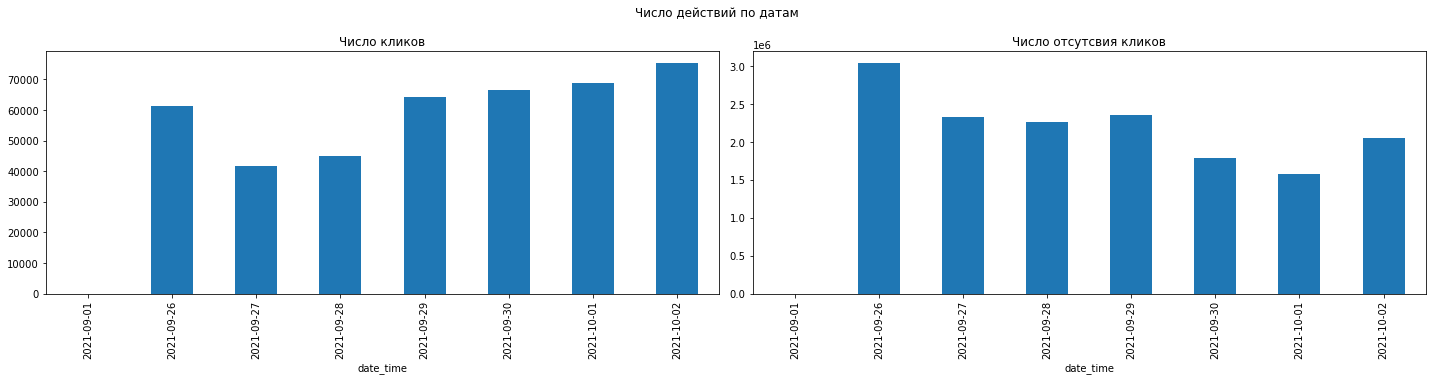


Число действий по дням недели:


,clicks
date_time,
0,2367303
1,2307355
2,2420589
3,1851189
4,1643448
5,2128978
6,3102610


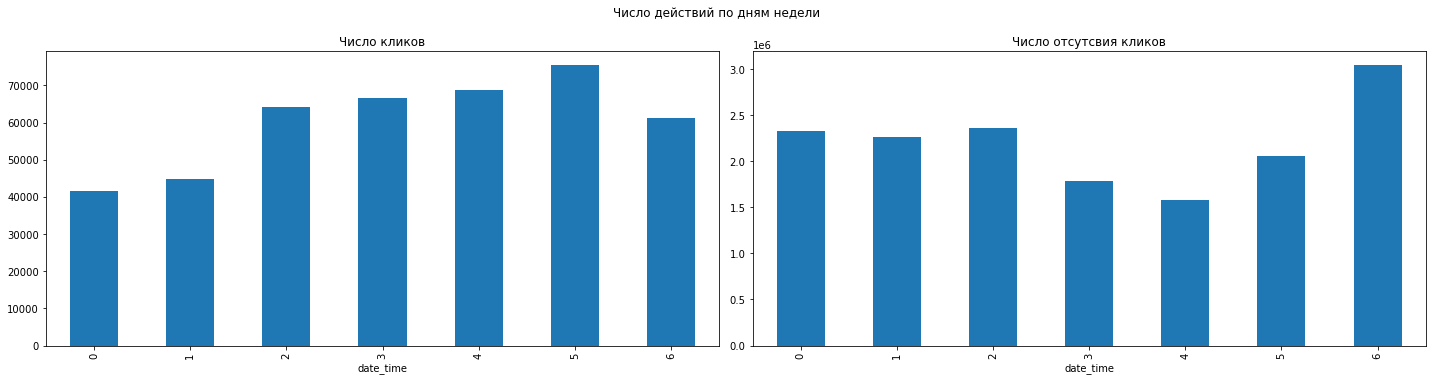


Число действий по месяцам:


,clicks
date_time,
9,12049046
10,3772426


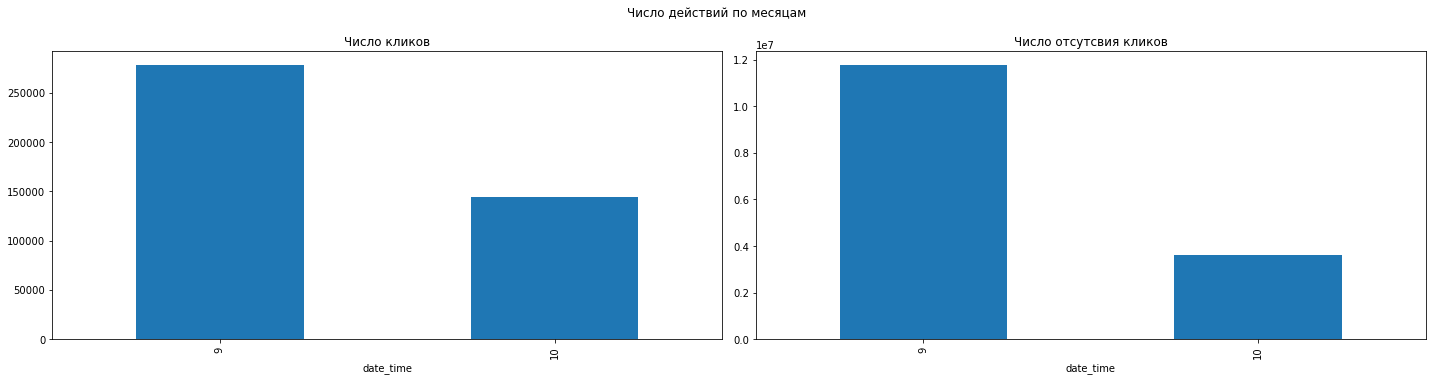


Число действий по часам:


,clicks
date_time,
0,550788
1,498533
2,482018
3,444033
4,405813
5,474251
6,476654
7,481859
8,547525


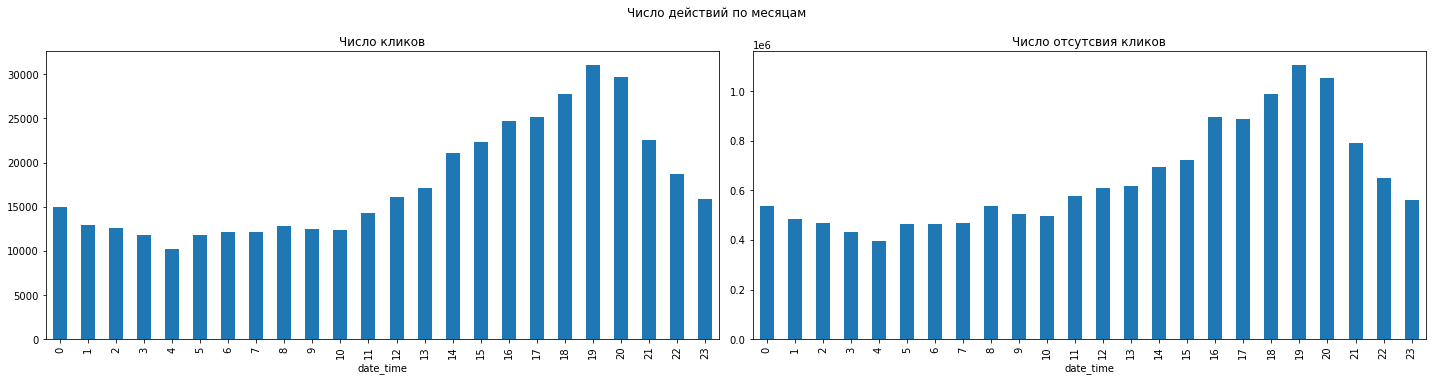

In [5]:
analysis(data)

## Итого мы имеем:
* все признаки, кроме campaign_clicks - категориальные
* между признаками нет сильной корреляции, что очень хорошо, тк нет необходимости убирать какие-то из них
* `impressions` всегда равняется 1, то есть показ всегда был, поэтому в дальнейшем можем убрать этот признак из анализа
* у нас имеется всего 8 дат, которые идут подряд, поэтому наверное выделение года и месяца особого смысла не имеет. Однако день недели может оказывать влияние на клики, поскольку можно предположить, что поведение в выходные дни может отличаться от рабочих.
* аналогично дню недели можно предположить что поведение пользователей в разное время дня может меняться, поэтому стоит его выделить.
* видно, что 01-09-2023 было совершено только одно действие, кажется можно его просто удалить



## Преобразование признаков

In [6]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    data.drop(['impressions'], axis=1, inplace = True)
    # убираем дату с 1 действием
    data = data[~(data.date_time.dt.date == datetime.date(2021, 9, 1))]
    # выделяем дату
    data['date'] = data.date_time.dt.date
    # выделяем день недели
    data['day_of_week'] = data.date_time.dt.dayofweek
    # выделяем время дня
    data['hour'] = data.date_time.dt.hour
    # сгруппируем часы в промежутки дня утро, день, вечер, ночь (утро с 6 до 12, обед с 12 до 18, вечер с 18 до 24, ночь с 24 до 6)
    bins = [0, 6, 12, 18,  24]
    labels = ['Ночь', 'Утро', 'Обед', 'Вечер'] 
    #data['time_of_day'] = pd.cut(data['hour'], bins=bins, labels=labels, right=False)
    
    features = list(set(data.columns) - set(['date_time','date']))
    
    #Деление на train-val-test


    # выделяем последний день на test, предпоследний на валидацию, все остальное - на обучение
    train_data = data[(data.date < datetime.date(2021,10, 1))][features]
    val_data = data[(data.date == datetime.date(2021,10, 1))][features]
    test_data = data[(data.date == datetime.date(2021,10, 2))][features]

    return train_data, val_data, test_data

In [7]:
train_data, val_data, test_data = feature_engineering(data) 

In [8]:
train_data.head()

,clicks,day_of_week,campaign_clicks,zone_id,hour,os_id,country_id,banner_id
0,1,0,0,0,0,0,0,0
1,1,6,0,1,22,0,1,1
2,1,6,3,2,23,0,0,2
3,1,0,0,3,0,1,1,3
4,1,0,0,4,0,1,0,4


## Подготовка данных

Для FFM входные данные должны быть в определенном формате(https://medium.com/@fareedkhandev/solve-large-scale-machine-learning-problem-in-python-58416f67c0ef#:~:text=For%20FFM%2C%20the%20input%20data%20should%20be%20in%20the%20libffm%20format.)

Буду использовать функцию для преобразования из:
https://github.com/wngaw/blog/blob/master/xlearn_example/src/utils.py

In [13]:
import json
import math
def convert_to_ffm(path, df, type, target, numerics, categories, features, encoder):
    # Flagging categorical and numerical fields
    #print('convert_to_ffm - START')
    for x in numerics:
        if(x not in encoder['catdict']):
            #print(f'UPDATING CATDICT: numeric field - {x}')
            encoder['catdict'][x] = 0
    for x in categories:
        if(x not in encoder['catdict']):
            #print(f'UPDATING CATDICT: categorical field - {x}')
            encoder['catdict'][x] = 1

    nrows = df.shape[0]
    with open(path + str(type) + "_ffm.txt", "w") as text_file:

        # Looping over rows to convert each row to libffm format
        for n, r in enumerate(range(nrows)):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow[target]))  # Set Target Variable here

            # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(encoder['catdict'].keys()):
                if(encoder['catdict'][x] == 0):
                    # Not adding numerical values that are nan
                    if math.isnan(datarow[x]) is not True:
                        datastring = datastring + " "+str(i)+":" + str(i)+":" + str(datarow[x])
                else:

                    # For a new field appearing in a training example
                    if(x not in encoder['catcodes']):
                        #print(f'UPDATING CATCODES: categorical field - {x}')
                        encoder['catcodes'][x] = {}
                        encoder['currentcode'] += 1
                        #print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    # For already encoded fields
                    elif(datarow[x] not in encoder['catcodes'][x]):
                        encoder['currentcode'] += 1
                        #print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    code = encoder['catcodes'][x][datarow[x]]
                    datastring = datastring + " "+str(i)+":" + str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)

    # print('Encoder Summary:')
    # print(json.dumps(encoder, indent=4))
    return encoder

In [14]:
#определяем списки фичей для передачи в функцию
target = 'clicks'
numer_feat = ['campaign_clicks','day_of_week','hour']
categ_feat = ['zone_id', 'os_id', 'country_id', 'banner_id']
features = numer_feat+categ_feat

In [15]:
encoder = {"currentcode": len(numer_feat),  # Unique index for each numerical field or categorical variables
           "catdict": {},  # Dictionary that stores numerical and categorical variables
           "catcodes": {}}  # Dictionary that stores index for each categorical variables per categorical field

In [16]:
#применяем функцию для train
encoder_train = convert_to_ffm('', train_data, 'train', target, numer_feat, categ_feat, features, encoder)

In [17]:
#применяем функцию для val
encoder_val = convert_to_ffm('', val_data, 'val', target, numer_feat, categ_feat, features, encoder)

In [18]:
#применяем функцию для test
encoder_test = convert_to_ffm('', test_data, 'test', target, numer_feat, categ_feat, features, encoder)

In [19]:
y_test = test_data['clicks']
y_val = val_data['clicks']

У меня не получилось установить xlearn локально, коллаб прерывал сеанс без каких-либо ошибок, поэтому последней надеждой был kaggle. Я залила полученные txt файлы в датасет ffm-format - https://www.kaggle.com/datasets/anastasiasmi/ffm-format/data

In [ ]:
params = {
    'task': ['binary'],
    'lr': [0.1],
    'lambda':[1e-2, 1e-3, 1e-4],
    'k': [2, 5, 7, 9]}

#df для хранения результатов обучения, чтобы потом было удобно сравнить модели
scores_df = pd.DataFrame(columns=["lambda", "k", "roc_auc", "log_loss"])

for param in ParameterGrid(params):
    
    #Обучаем модель
    print('Рассматриваемые параметры: ' + '\n' + str(param))
    ffm_model = xl.create_ffm()
    ffm_model.setTrain("/kaggle/input/ffm-format/val_ffm.txt")
    ffm_model.setValidate("/kaggle/input/ffm-format/train_ffm.txt")
    ffm_model.fit(param, f"./model_l_{param['lambda']}_k_{param['k']}.out")
    ffm_model.setSigmoid()
    
    #Применяем модель
    ffm_model.predict(f"./model_l_{param['lambda']}_k_{param['k']}.out', f'./y_pred_l_{param['lambda']}_k_{param['k']}.txt")
    y_pred = np.genfromtxt(f"y_pred_l_{param['lambda']}_k_{param['k']}.txt", dtype=float)
    log_loss_sc = log_loss(y_test, y_pred)
    roc_auc_sc = roc_auc_score(y_test, y_pred)
    print('Результаты:')
    print("Log Loss:", log_loss_sc)
    print("ROC AUC:", roc_auc_sc)

    scores_df = scores_df.append({
    "lambda": param['lambda'],
    "k": param['k'],
    "roc_auc": roc_auc_sc,
    "log_loss": log_loss_sc,}, ignore_index=True)

В результате, я так и не смогла его победить. kaggle хотя-бы выдавал следующую информацию, после чего вылетал:
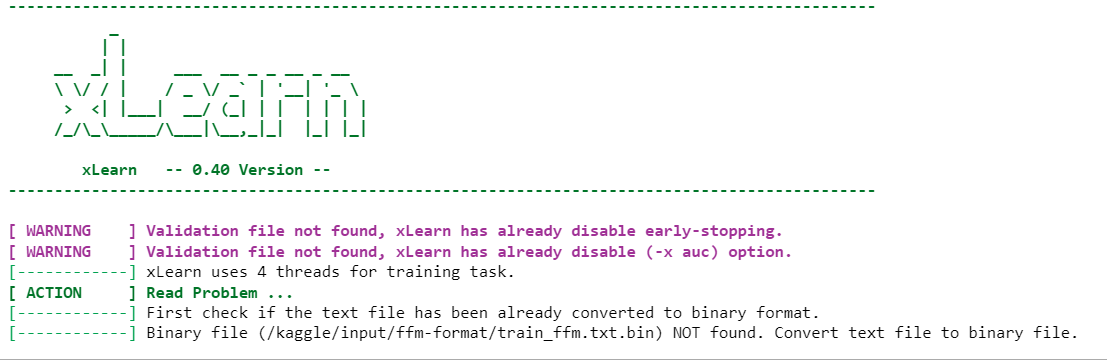

In [ ]:
scores_df